# Life Expectancy -- Normalization, Regularization, Feature Selection

Last class we created a linear model for the WHO life expectancy database. Today we will focus on various ways to interpret the model and refine it, specifically by interpreting the importance of each model feature and selecting a subset of features that make our model more interpretable and more extensible.

Outline

1. Linear regression coefficients
2. Normalizing the inputs
3. Ridge Regression (L2)
4. Lasso Regression (L1)
5. Conclusions

In [47]:
import pandas as pd
import os
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

Let's copy our code to load and process the dataset

In [49]:

# We'll fetch it directly from the web
data_url = "https://aet-cs.github.io/white/ML/lessons/Life_Expectancy_Data.csv"
df = pd.read_csv(data_url)
target = "Life expectancy"    

# And save locally. You may need to edit data_root
data_root = "../data"
filepath = "Life_Expectancy_Data.csv"
filepath = os.path.join(data_root, filepath)

df.to_csv(filepath, index=False)
df.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


In [50]:
def get_data(filepath):
    df = pd.read_csv(filepath)
    return df    

For today's exercise we will remove country feature. From last class it was obvious that counry has a tremendous impact on life expectancy. But we're interested in more general relationships. We want to see what can be said without relying on knowledge of the country. So our preprocessing method will drop the country.

In [51]:
def pre_process_data(df, one_hot_encode = False):
    target = "Life expectancy"    

    # Use sklearn Imputers to fill in the categorical and numerical columns
    simple_median = SimpleImputer(strategy='median')
    simple_most_freq = SimpleImputer(strategy='most_frequent')
    
    num_cols = df.select_dtypes(include=np.number).columns # numerical data
    cat_cols = df.select_dtypes(include=object).columns # categorical data

    df[num_cols] = simple_median.fit_transform(df[num_cols])
    df[cat_cols] = simple_most_freq.fit_transform(df[cat_cols])
    
    if one_hot_encode:
        O_encoder = OrdinalEncoder()
        df[cat_cols]= O_encoder.fit_transform(df[cat_cols])

        # df = pd.get_dummies(df, dtype=int)

    df = df.drop("Country", axis=1)
    return df

We add a method here to drop features. We will only use this sometimes, so it is not a part of "pre_process_data"

In [52]:
def feature_selection(df):
    df = df.drop(["under-five deaths", "Diphtheria", "thinness 1-19 years", "Polio"], axis = 1)
    return df

The random_state logic here is a bit different. We want randomized training set selection as the default so unless the caller sets `random_state=true`, we return a different training_set each time

In [53]:
def get_test_train(df, test_size = 0.2, random_state = False):
    target = "Life expectancy"    
    X = df.drop(target, axis=1)
    y = df[target]
    if random_state:
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size, random_state=42)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size)
    return X_train, X_test, y_train, y_test

## First Linear Model

Let's do a vanilla linear regression and check the results. Notice the use of `model.score` to get an $r^2$ score. Each model has a different `score` method (usually $r^2$ for regression). Also note the use of python "f-string" which interpolate variable values into strings. There is also a format specifier in this case indicating 3 decimal places to be printed.

In [54]:
df = get_data(filepath)
df = pre_process_data(df, one_hot_encode = True)
X_train, X_test, y_train, y_test = get_test_train(df)
lreg = LinearRegression()
model = lreg.fit(X_train, y_train)

In [55]:
pred = lreg.predict(X_test)
print(f"Train R-squared  = {model.score(X_train, y_train):.3}")
print(f"Test  R-squared  = {model.score(X_test, y_test):.3}")

Train R-squared  = 0.818
Test  R-squared  = 0.822


Because of the random state, the previous two cells will return slightly different results each time.

Let's plot the coefficients. Note how the `model` object contains the coefficients. The underscore "_" in the variable name is a convention in Python that communicates the idea of a "Java private" field, except it's not private. This is an internal field that you should *not* mess with unless you know what you're doing. But you can read it all day long without fear.

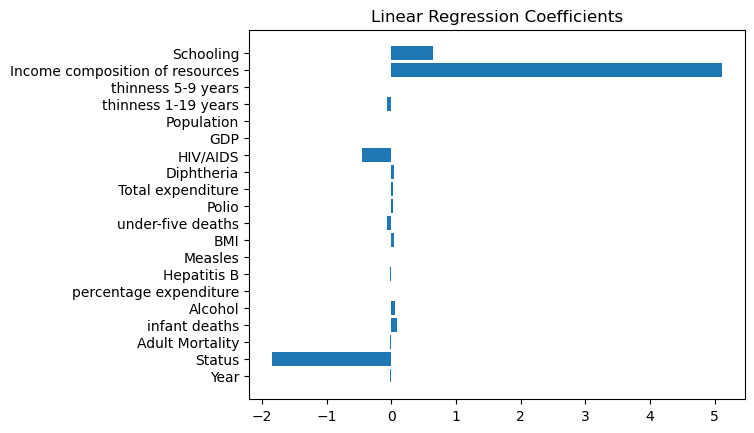

In [56]:
plt.barh(y = df.drop(target,axis=1).columns, width=model.coef_);
plt.title("Linear Regression Coefficients");

Look closely at this graph. We discussed how the coefficient here is a measure of importance. If, for example, `HIV/AIDS` increases by one unit, then the life expectancy should decrease by about 0.5 units. Of course the units vary from feature to feature. So comparing these coefficients directly is basically impossible. We'll fix this in the next section.

But first, let's get a sense of the *stability* of our model. Each time we get a train/test split, it gives us a different $r^2$ value. If we repeat the selection and fit process 50 times, the range of values gives us a sense of the model's stability and also a better assessment of our real score. Write some code that

1. Runs a linear model 50 times (start from scratch: `df = get_data(filepath)` to be safe
2. Collects the scores on the *test data*
3. Makes a scatter plot of the scores
4. Prints the mean and stdev of the scores

Linear Model: Mean score = 0.813 Stdev = 0.0121


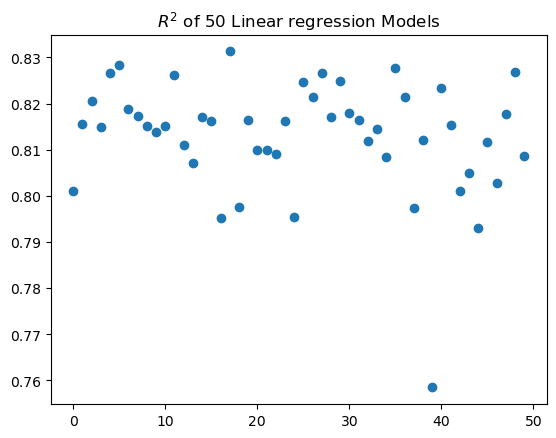

In [57]:
scores = []
for i in range(50):
    df = get_data(filepath)
    df = pre_process_data(df, one_hot_encode = True)
    X_train, X_test, y_train, y_test = get_test_train(df)
    lreg = LinearRegression()
    model = lreg.fit(X_train, y_train)
    scores += [model.score(X_test, y_test)]
plt.scatter(x = range(len(scores)), y = scores);
plt.title("$R^2$ of 50 Linear regression Models")
print(f"Linear Model: Mean score = {np.mean(scores):.3} Stdev = {np.std(scores):.3}")

## Feature Normalization

The data has come to us in vastly different scales. Population can be in the billions, and percent expendature is close to 1. A standard best practice is to scale your input features before modeling. In this case we transform each feature $x_i$ by

$$x_i \leftarrow \dfrac{x_i - \mu_i}{\sigma_i}$$

which sets the mean to 0 and the new standard deviation to 1. 

To simplify things, we'll just redefine `get_test_train`. (We could scale the features earlier in preprocessing, but sklearn returns a matrix here, not a dataframe. So we would have to reconstitute the dataframe after scaling. This way is simpler and works for now.)

In [58]:
def get_test_train(df, test_size = 0.2, random_state = False):
    target = "Life expectancy"    
    X = df.drop(target, axis=1)

    # add a scaler here. It works by finding a fit first (computing mu and sigma)
    scaler = StandardScaler().fit(X)
    # and then transforming the data
    X = scaler.transform(X)
    
    y = df[target]
    if random_state:
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size, random_state=42)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size)
    return X_train, X_test, y_train, y_test

Linear Model: Mean score = 0.815 Stdev = 0.0146


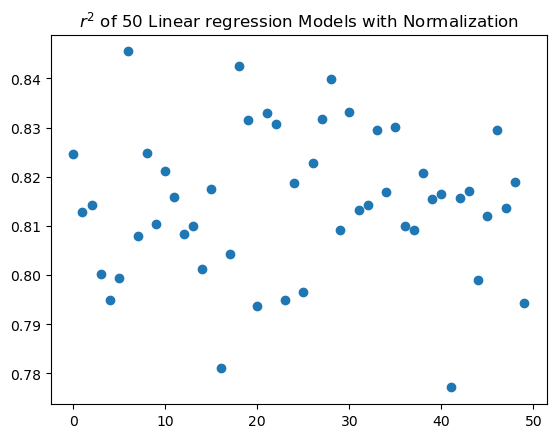

In [59]:
scores = []
for i in range(50):
    df = get_data(filepath)
    df = pre_process_data(df, one_hot_encode = True)
    X_train, X_test, y_train, y_test = get_test_train(df)
    lreg = LinearRegression()
    model = lreg.fit(X_train, y_train)
    scores += [model.score(X_test, y_test)]
plt.scatter(x = range(len(scores)), y = scores);
plt.title("$r^2$ of 50 Linear regression Models with Normalization")
print(f"Linear Model: Mean score = {np.mean(scores):.3} Stdev = {np.std(scores):.3}")

Schooling coefficient: 2.23


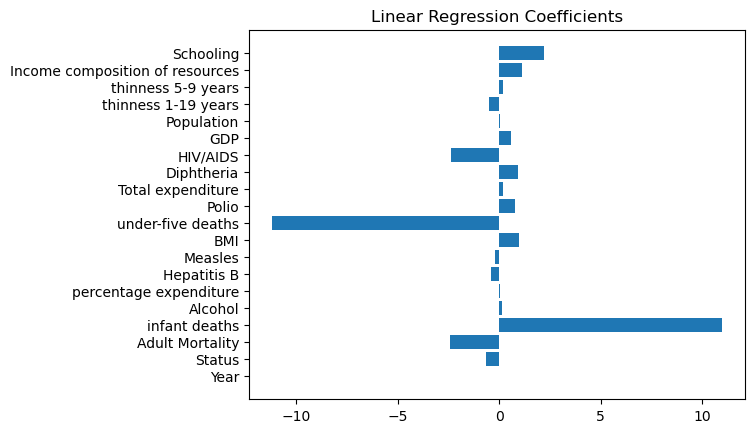

In [60]:
plt.barh(y = df.drop(target,axis=1).columns, width=model.coef_);
plt.title("Linear Regression Coefficients")
print(f"Schooling coefficient: {model.coef_[-1]:.3}") # the last/top coeff is schooling

These coefficients are now in units of (years/standard deviation). If schooling increases by about $1\sigma = 3.3589$ years then life expectancy increases by about 2 years (we did not scale the target). Normalization definitely helps with interpretations. But there are still some weird things going on here? **Discuss**

## Eliminating Collinearity

In the last lab we saw how collinear features can increase the condition number of the linear least squares regression matrix, which leads to possibly unstable solutions. It also interferes with the interpretability of regression coefficients. If 2 features are already related (e.g. $x_1 = -0.3 x_2$, then either regression coefficient can change arbitrarily as long as its paired coefficient changes in tandem. By manually dropping highly correlated features we can reduce this effect somewhat (although we can't eliminate it entirely. If you look at the correlation heatmap, there is a lot is cross-correlation in this dataset.)

Repeate the analysis from the last section here, but first drop collinear columns. A method has been defined for you. Feel free to modify which subset of columns are dropped. You should create both

1. A scatter plot of 50 regression model scores, with dropped features
2. A Coefficients horizontal bar plot of one of the models

Linear Model: Mean score = 0.783 Stdev = 0.0151


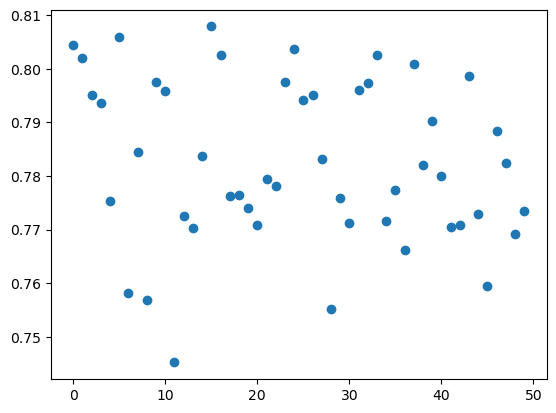

In [61]:
scores = []
df = feature_selection(df)
for i in range(50):
    X_train, X_test, y_train, y_test = get_test_train(df)
    lreg = LinearRegression()
    model = lreg.fit(X_train, y_train)
    scores += [model.score(X_test, y_test)]
plt.scatter(x = range(len(scores)), y = scores);
print(f"Linear Model: Mean score = {np.mean(scores):.3} Stdev = {np.std(scores):.3}")

Schooling coefficient: 2.38


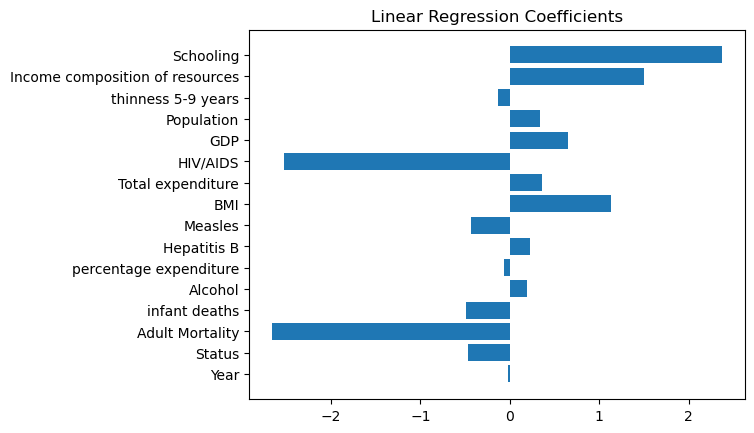

In [16]:
plt.barh(y = df.drop(target,axis=1).columns, width=model.coef_);
plt.title("Linear Regression Coefficients")
print(f"Schooling coefficient: {model.coef_[-1]:.3}") # the last/top coeff is schooling

Compare these results to the non-dropped results. **Discuss**

As a final analysis, it is interesting to see how the regression coefficients change as a result of the training set selection. We have been warned this model may be unstable. If this results in wildly varying regression coefficients, then we should doubt the validity of our model.

In [62]:
coefs = []
for a in range(200):
    df = get_data(filepath)
    df = pre_process_data(df, one_hot_encode = True)
    df = feature_selection(df)
    X_train, X_test, y_train, y_test = get_test_train(df)
    lreg = LinearRegression()
    model = lreg.fit(X_train, y_train)
    coefs.append(model.coef_)

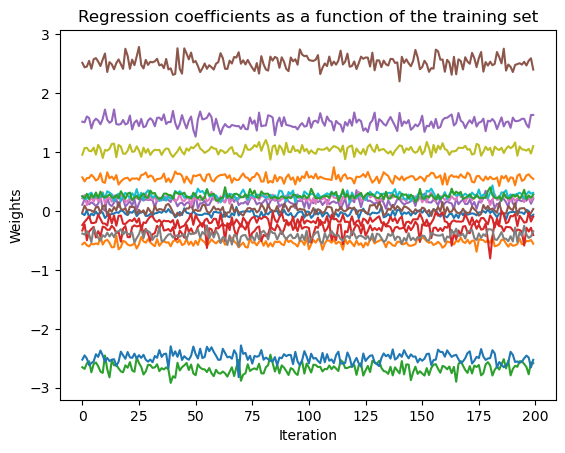

In [63]:
ax = plt.gca()
ax.plot(range(200), coefs)
plt.xlabel("Iteration")
plt.ylabel("Weights")
plt.title("Regression coefficients as a function of the training set")
plt.axis("tight")
plt.show()

These weights look pretty stable to me. So I think we're OK with this regression model.

## Ridge Regression

While our current linear model is relatively stable to training set fluctuations, it still exhibits a wide range of weights.

In [65]:
c = np.abs(model.coef_)
print(f"Ratio of largest to smallest coefficient: {np.max(c)/np.min(c): 0.5}")

Ratio of largest to smallest coefficient:  75.538


It is possible to drive these weights to be closer together by applying a regularization technique to our optimization model. We add a term to the error function that penalizes large coefficients. Normally in linear regression the error (loss) function for $m$ observations and $n$ features is

$$err = \sum_{i=1}^m (y_i - \tilde{y}_i)^2$$

We change this to

$$err_{\alpha} = \sum_{i=1}^m (y_i - \tilde{y}_i)^2 + \alpha \sum_{i = 0}^{n} a_i^2$$

where the $a_i$ are the computed fit coefficients and $\alpha$ is a tunable parameter of the model. This is called *ridge* regression ($L_2$ regularization) and is available in scikit-learn. The larger $\alpha$ penalizes coefficients more and drives them smaller. Because of the squared term, large coefficients are penalized relatively more than small ones and will decrease at a faster rate.

To see the effect of ridge regression, we run 200 trials with $\alpha$ varying from $1$ to $10^6$. 

In [66]:
n_alphas = 200

# create a list from 10^6 down to 10^0, log spaced
alphas = np.logspace(6,0, n_alphas)

# run a ridge regression for each alpha
coefs = []

# We perform this on the full dataset -- NO feature selection
df = get_data(filepath)
df = pre_process_data(df, one_hot_encode = True)
df = feature_selection(df)
X_train, X_test, y_train, y_test = get_test_train(df)
for a in alphas:
    ridge = Ridge(alpha=a, fit_intercept=False)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

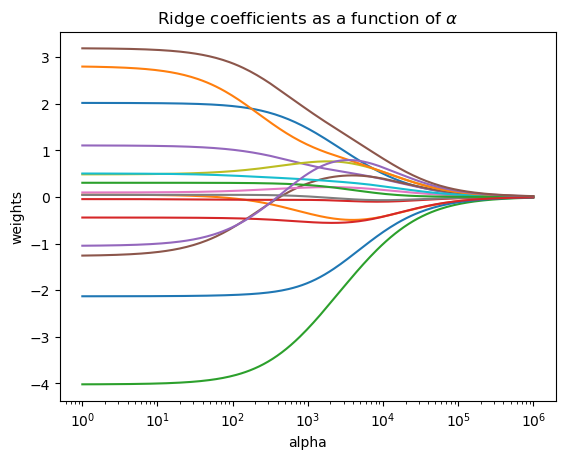

In [67]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of $\\alpha$ ")
plt.axis("tight")
plt.show()

We pick $\alpha=10^3$ and interpret the results. 

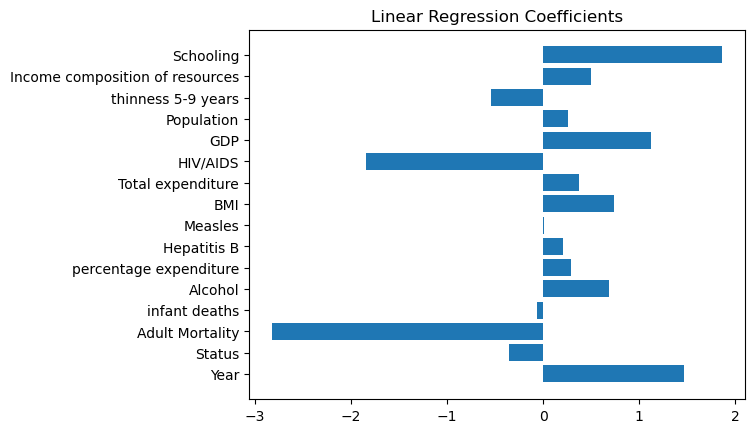

In [68]:
ridge = Ridge(alpha=1000, fit_intercept=False)
ridge.fit(X_train, y_train)
plt.barh(y = df.drop(target,axis=1).columns, width=ridge.coef_);
plt.title("Linear Regression Coefficients");

In [71]:
c = np.abs(ridge.coef_)
print(f"Ratio of largest to smallest coefficient: {np.max(c)/np.min(c): 0.5}")

Ratio of largest to smallest coefficient:  276.05


The ratio hasn't decreased all that much. You should

1. Experiment with different alpha values.
2. Then, go back to the dataset and try dropping the collinear columns again.

What effect does this have? **Discuss** 

There is a bit of art and science in regularizing data. Ridge regression may not be doing much for us. Let's try another method.

## Lasso Regression

Lasso regression ($L_1$ regularization) uses the error (loss) function

$$err_{\alpha} = \sum_{i=1}^m (y_i - \tilde{y}_i)^2 + \alpha \sum_{i = 0}^{n} |a_i|$$

This has the interesting mathematical effect of not just decreasing the magnitude of coefficient but actually driving coefficients to zero. The result is that the remaining features with non-zero coefficients can be interpreted as "most important" and lead to a simpler model with similar accuracy to a larger model.

Lasso regression is also built into scikit-learn. Let's do a similar analysis. (This next loop may throw some warning. You can disgregard them.)

In [72]:
n_alphas = 200
alphas = np.linspace(0,4, n_alphas)

coefs = []

# We perform this on the full dataset -- NO feature selection
df = get_data(filepath)
df = pre_process_data(df, one_hot_encode = True)
X_train, X_test, y_train, y_test = get_test_train(df)

import warnings
warnings.filterwarnings("ignore")
for a in alphas:
    lasso = Lasso(alpha=a, fit_intercept=True)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

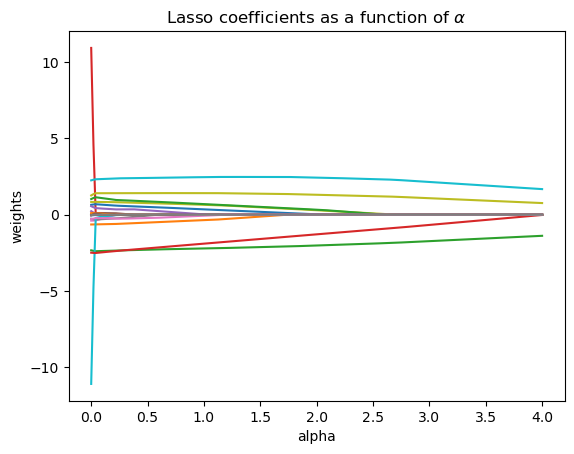

In [73]:
ax = plt.gca()
ax.plot(alphas, coefs)
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Lasso coefficients as a function of $\\alpha$")
plt.axis("tight")
plt.show()

Based on the above graph, pick an $\alpha$ value for your regression model in the cell below. We will see a number of the features *completely disappear* from the model.

Score on test set 0.796


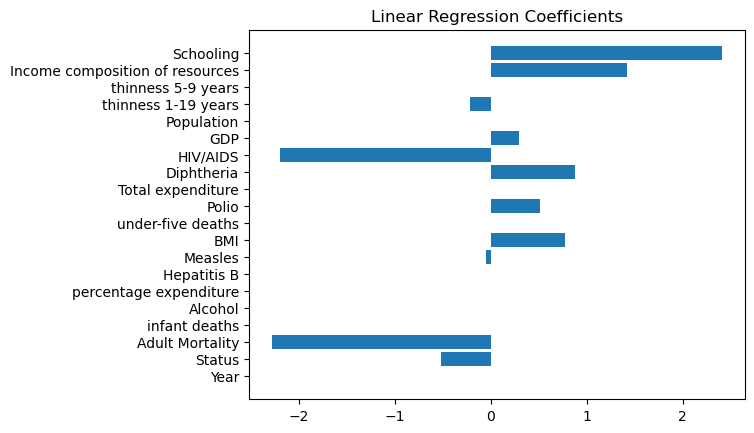

In [74]:
alpha = 0.5

lasso = Lasso(alpha=alpha, fit_intercept=True)
lasso.fit(X_train, y_train)
plt.barh(y = df.drop(target,axis=1).columns, width=lasso.coef_);
plt.title("Linear Regression Coefficients");
print(f"Score on test set {lasso.score(X_test, y_test):.3}")

We can filter out the non-zero features and sort the result

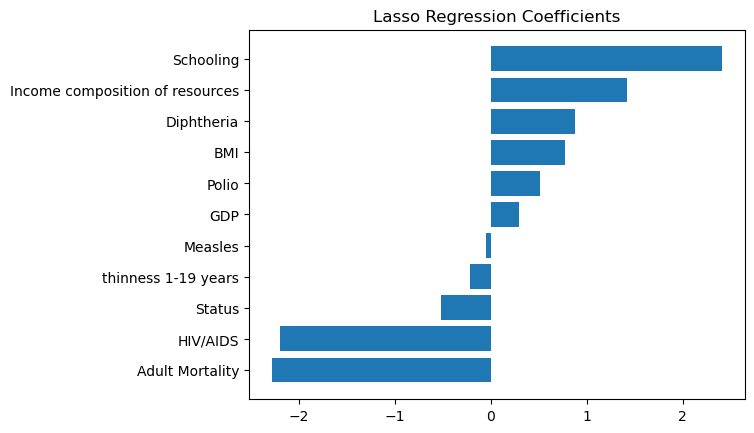

In [75]:
results = pd.DataFrame(np.array([df.drop(target,axis=1).columns, lasso.coef_]).T, columns = ['feature', 'coeff'])

filtered_results = results[abs(results['coeff'])>0].sort_values(by='coeff')

plt.barh(y = 'feature', width='coeff', data = filtered_results);
plt.title("Lasso Regression Coefficients");

This model is much smaller than the original, which means it is maybe easier to interpret. Let's see if our accuracy has diminished any?

Linear Model: Mean score = 0.796 Stdev = 0.0122


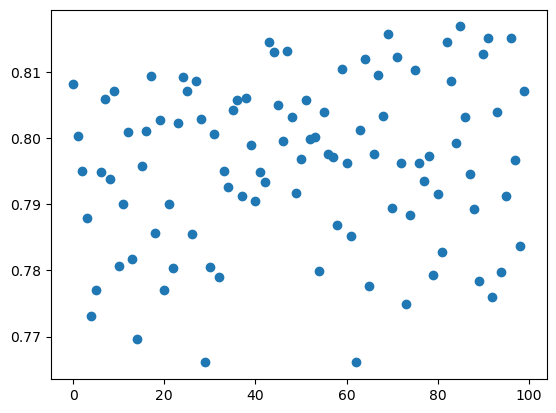

In [76]:
scores = []
for i in range(100):
    df = get_data(filepath)
    df = pre_process_data(df, one_hot_encode = True)
    X_train, X_test, y_train, y_test = get_test_train(df)
    lasso = Lasso(alpha=alpha, fit_intercept=True)
    model = lasso.fit(X_train, y_train)
    scores += [model.score(X_test, y_test)]
plt.scatter(x = range(len(scores)), y = scores);
print(f"Linear Model: Mean score = {np.mean(scores):.3} Stdev = {np.std(scores):.3}")

**Rerun** the last few cells with different alpha values and decide which alpha you like the best